# Classification with Segment Network-v2
* Are we really learning the image? Applying a decoder didn't show any think like the image we fed in.
* so change in plan. use decoder after seg2 (no need for seg1) to calculate loss.

#### TODO for later
* Goal: v1 classification with SegmentNet worked well but we had to flatten the image. This probably leads to too many parameters as each flatten pixel is compared with every other in layer 1 & 2.
* This network will try to not flatten the image.
* Option 1: Create a new class that works on one row and see if we can call it in loop.
* Option 2: Modify segment network to support a new dimension for rows. 


# Initialization

In [16]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import time
from tqdm import tqdm

from segment import Segment
from decoder import Decoder

In [17]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [18]:
def set_random_seeds(seed_value=42):
    """Sets all possible random seeds so results can be reproduced."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seeds()

# MNIST dataset

In [19]:
from typing import Any
from torchvision import datasets, transforms

flatten_by_row_transform = transforms.Lambda(lambda x: x.flatten())
flatten_by_col_transform = transforms.Lambda(lambda x: x.permute(0,2,1).flatten())
bw_array_transform = transforms.Lambda(lambda x: torch.where(x < x.mean(), 0., 1.))
position_transform = transforms.Lambda(lambda x: x*torch.arange(1, x.shape[0]+1.)/x.shape[0] )

class subtract_pos_transform():
    """
    NOTE: This transform creates output tensor of size N*(N-1)/2 (N is the length of the input tensor
    This is too large.

    Args:
    tensor (Tensor): Tensor 1D flattened image from position transform.

    Returns:
        Tensor: Tensor with pixel differences from other non zero pixels.
    """
    def __call__(self, tensor) -> Any:
        diff_matrix = tensor.view(tensor.shape[0],1) - tensor
        results = []
        for i in range(diff_matrix.size(0)):
            results.append(diff_matrix[i, i+1:])

        return torch.cat(results).flatten()

train_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.RandomRotation(15),
    #bw_array_transform,
    flatten_by_row_transform
    #position_transform
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    #bw_array_transform,
    flatten_by_row_transform
    #position_transform
])

train_set = datasets.MNIST('data', train=True, download=False, transform=train_transform)
test_set = datasets.MNIST('data', train=False, download=False, transform=test_transform)
print(len(train_set), len(test_set))
print(train_set[0][0].shape, test_set[0][0].shape)

60000 10000
torch.Size([784]) torch.Size([784])


# Model Definition

In [20]:
# Remove seg1 from the model, use decoder to evaluate output of seg2x,y

# Version 2.0
class MyModel(nn.Module):
    def __init__(self, input_size, batch_size, segment1_size, segment2_size, segment3_size, output_dim):
        super().__init__()
        self.init = False
        #self.seg1 = Segment(1, batch_size, segment1_size)
        seg2_output_size = segment1_size+1
        self.x_in = None
        #split seg2 into x,y parts to reduce unnecessary parameters
        self.seg2x = Segment(input_size, seg2_output_size, segment2_size)
        self.seg2y = Segment(input_size, seg2_output_size, segment2_size)
        self.decoder = Decoder(torch.Tensor([input_size]))
        self.seg3 = Segment(2*seg2_output_size, output_dim, segment3_size)
        
    def custom_init(self, x):
        #x_min = torch.zeros(self.seg1.in_features, dtype=x.dtype)
        #x_max = torch.ones(self.seg1.in_features, dtype=x.dtype)
        #self.seg1.custom_init(x_min, x_max)
        x_min = torch.zeros(self.seg2x.in_features, dtype=x.dtype)
        x_max = torch.ones(self.seg2x.in_features, dtype=x.dtype)
        self.seg2x.custom_init(x_min, x_max)
        self.seg2y.custom_init(x_min, x_max)
        x_min = torch.zeros(self.seg3.in_features, dtype=x.dtype)
        x_max = torch.ones(self.seg3.in_features, dtype=x.dtype)
        self.seg3.custom_init(x_min, x_max)
        
        self.init = True

    def forward(self, x):
        if self.training:
            if not self.init:
                self.custom_init(x)
            
            #Train a model1 that predicts x,y for the input x_in so output is x
            #self.x_in = torch.arange(1, x.shape[1]+1.)/x.shape[1]
            #self.x_in.unsqueeze_(-1)
            #y1 = self.seg1(self.x_in)
            #loss1 = F.mse_loss(y1, x.permute(1,0))

        
        self.xembeddings = self.seg2x(x)
        self.yembeddings = self.seg2y(x)
        self.xout = self.decoder(segment_x=self.xembeddings, segment_y=self.yembeddings)
        
        if self.training:
            loss1 = F.mse_loss(x, self.xout)
            #seg1_xparams = self.seg1.x.view(self.seg1.x.shape[2], self.seg1.x.shape[1])
            #seg1_yparams = self.seg1.y.view(self.seg1.y.shape[2], self.seg1.y.shape[1])
            #loss2x = F.mse_loss(self.xembeddings, seg1_xparams)
            #loss2y = F.mse_loss(self.yembeddings, seg1_yparams)
            
        
        self.embeddings = torch.cat((self.xembeddings, self.yembeddings), dim=1)
        ypred = self.seg3(self.embeddings)

        if self.training:
            return loss1, ypred
        else:
            return ypred
    

# Model Training

In [22]:
# Define Model : 1 input, 1 output, play with segments starting from 1/2 of image pixels.
BATCH_SIZE=64
set_random_seeds()

model = MyModel(784, 64, 14, 3, 10, 10).to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
#total_params = sum(p.numel() for p in model.seg1.parameters())
#print(f"Seg1 parameters: {total_params}")
total_params = sum(p.numel() for p in model.seg2x.parameters())
print(f"Seg2(x,y) parameters: {total_params}, {total_params}")
total_params = sum(p.numel() for p in model.seg3.parameters())
print(f"Seg3 parameters: {total_params}")

MyModel(
  (seg2x): Segment(in_features=784, out_features=15, segment_features=3)
  (seg2y): Segment(in_features=784, out_features=15, segment_features=3)
  (decoder): Decoder()
  (seg3): Segment(in_features=30, out_features=10, segment_features=10)
)
Total parameters: 194760
Seg2(x,y) parameters: 94080, 94080
Seg3 parameters: 6600


In [1]:
criterion = nn.CrossEntropyLoss()

lr=1e-4
#optimizer only optimizes parameter that are sent to it in arg1
optimizer = torch.optim.AdamW(model.parameters(),
                               lr=lr, betas=(0.9, 0.999), eps=1e-8)
num_epochs = 40

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

start = time.time()
training_losses = np.empty((0, 2))
val_losses = np.empty((0))
val_accuracies = np.empty((0))
for epoch in tqdm(range(1,num_epochs+1), position=0, leave=True):
    model.train()
    t0 = time.time()
    step = 0
    epoc_losses = np.zeros((2))
    for data in tqdm(train_dataloader, position=0, leave=True):
        img, label = data

        #don't train for wrong batch size for now
        if img.shape[0] != BATCH_SIZE:
            continue

        # ===================forward=====================
        loss1, y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)
        class_loss = criterion(y_pred, label)
        if(math.isnan(class_loss)):
            print(f"nan class_loss at step {step}")
            break
                
        optimizer.zero_grad()
        loss = loss1 + class_loss
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            epoc_losses[0] += loss1.item()
            epoc_losses[1] += class_loss.item()

        step += 1
    # ===================log========================
    t1 = time.time()
    training_losses = np.append(training_losses, [epoc_losses/len(train_dataloader)], axis=0)
    
    if(math.isnan(class_loss)):
        print(f"nan class_loss ")
        break

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for data in tqdm(test_dataloader, position=0, leave=True):
            img, label = data
            #don't test for wrong batch size for now
            #if img.shape[0] != BATCH_SIZE:
            #    continue
            y_pred = model(img.to(device))
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss/len(test_dataloader)
    val_losses = np.append(val_losses, val_loss)
    val_accuracy = sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels)
    val_accuracies = np.append(val_accuracies, val_accuracy)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch}: {epoc_losses/len(train_dataloader)}")
    print(f"Valid Loss EPOCH {epoch}: {val_loss:.4f}")
    #print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch}: {val_accuracy:.4f}")
    print("-"*30)

    if (epoch % 10 == 0):
        torch.save(model.state_dict(), f"class_seg_v2_{epoch}.pth")

stop = time.time()
print(f"Training Time: {stop-start:.2f}s")

NameError: name 'nn' is not defined

# Plot Losses

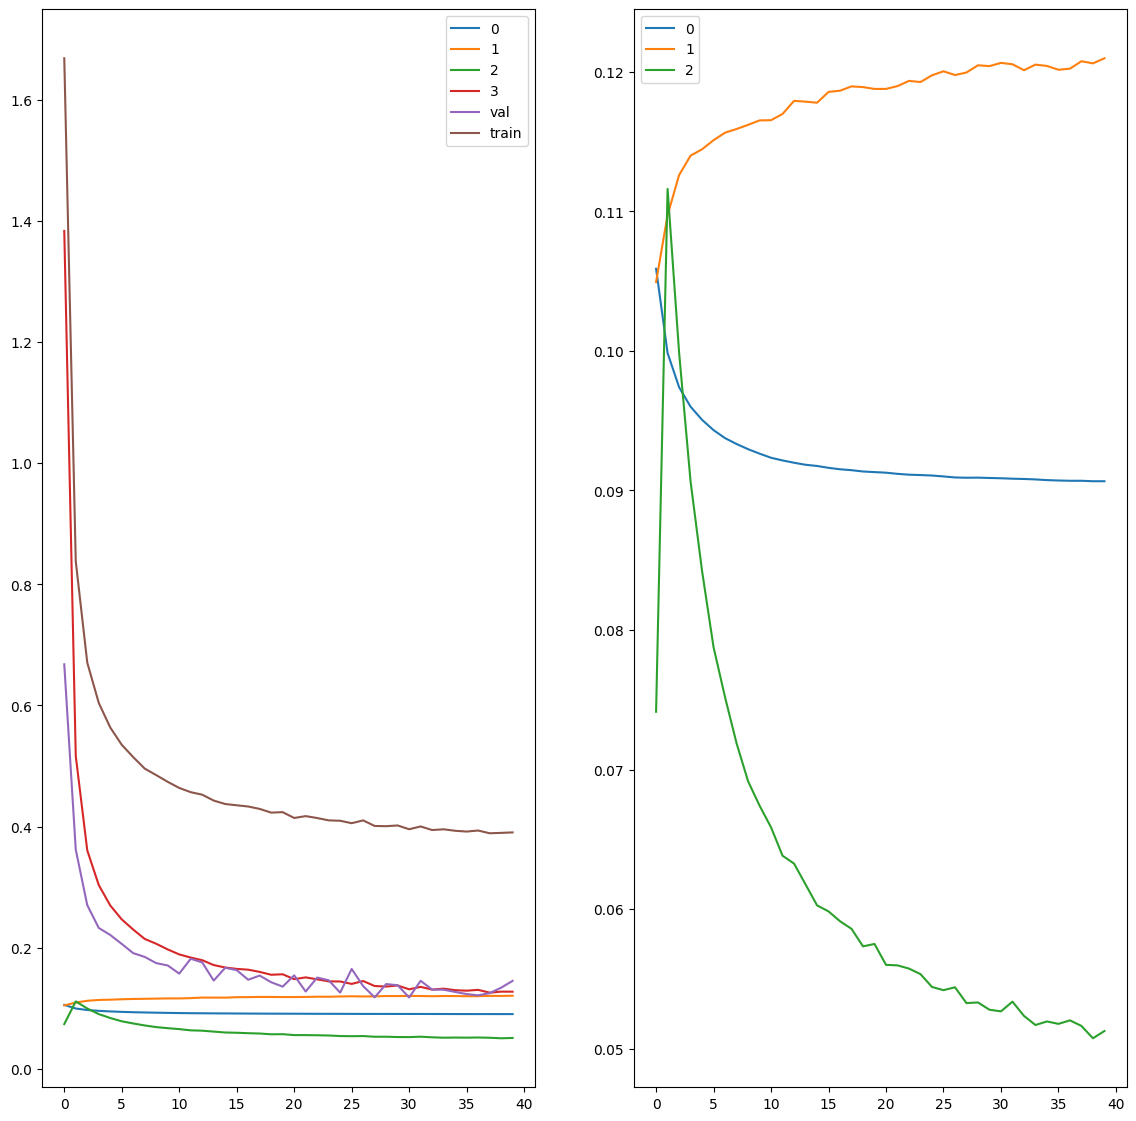

In [11]:
# Plot all losses
fig = plt.figure(figsize=(14, 14))
ax1 = fig.add_subplot(121)

x = np.arange(0, len(training_losses[:,0]+1))
for i in range(4):
    ax1.plot(x,training_losses[:,i], label=str(i))

ax1.plot(x,val_losses, label='val')
ax1.plot(x,np.sum(training_losses,axis=1), label='train')
ax1.legend()

ax2 = fig.add_subplot(122)
for i in range(3):
    ax2.plot(x,training_losses[:,i], label=str(i))

ax2.legend()
plt.show()

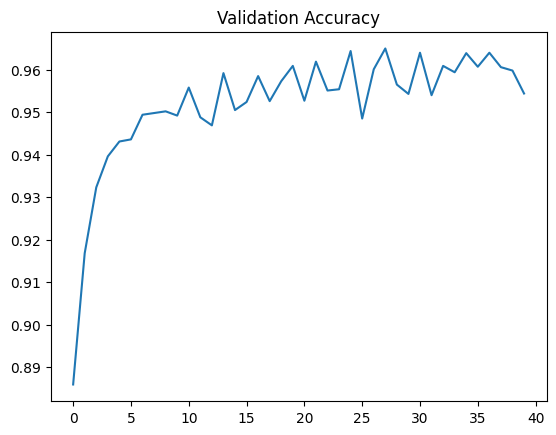

In [10]:
# Plot only 1st Validation Accuracy
x = np.arange(0, len(training_losses[:,0]+1))
plt.plot(x,val_accuracies)
plt.title('Validation Accuracy')
plt.show()

In [ ]:
# Save graph to a file
#!pip install torchviz
from torchviz import make_dot

# Generate a Graphviz object from the computation graph
#graph = make_dot(loss, params=dict(model.named_parameters())) 

# Save the graph as a PDF or any other format if needed
#graph.render("model_Classification_Segment_v2_graph")

In [12]:
# Max accuracy
val_accuracies.max(), val_losses.min(), val_accuracies[:50].mean()

(0.965, 0.11806433726173297, 0.95196)

# Use Decoder to regenerate test images

In [25]:
for data in test_dataloader:
    img, label = data
    break

print(img.shape, label.shape)


torch.Size([64, 784]) torch.Size([64])


In [7]:
img, label = test_set[3]
print(img.unsqueeze(0).shape, label)
model.eval()
y_pred = model(img.unsqueeze(0))
y_pred_label = torch.argmax(y_pred, dim=1)
print(model.xembeddings.shape,model.yembeddings.shape, y_pred_label.item())

torch.Size([1, 784]) 0
torch.Size([1, 15]) torch.Size([1, 15]) 0


In [8]:
image_shape = torch.Tensor([img.shape[0]])
decoder = Decoder(image_shape)
ydecoded = decoder(segment_x=model.xembeddings, segment_y=model.yembeddings)
print(ydecoded.shape)
loss = F.mse_loss(ydecoded[0], img)
print(loss)

torch.Size([1, 784])
tensor(nan, grad_fn=<MseLossBackward0>)


torch.Size([1, 28, 28])


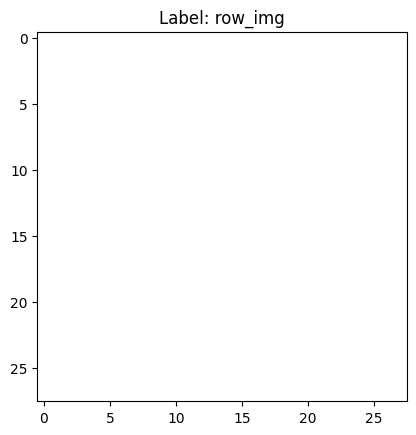

In [9]:
# Draw the image
unflatten_by_row_transform = transforms.Lambda(lambda x: x.view([1,28,28]))

row_img = unflatten_by_row_transform(ydecoded[0])
print(row_img.shape)
plt.imshow(row_img.squeeze().detach().numpy(), cmap='gray')
plt.title(f"Label: row_img")
plt.show()

In [11]:
from torch.profiler import profile, record_function, ProfilerActivity
if torch.backends.mps.is_available():
    print("PyTorch has MPS support.")
else:
    print("MPS might not be available or used.")

with profile(activities=[
        ProfilerActivity.CPU,  # Profile CPU activity
        ProfilerActivity.CUDA  # Profile CUDA activity (if a CUDA device is present)
        #ProfilerActivity.MPS    # Profile MPS activity (if available)
    ],
    record_shapes=True  # Optionally record input shapes for operations
) as prof:
    model = MyModel(784, 64, 14, 3, 10, 10)
    y_pred = model(img.unsqueeze(0))

# After the `with` block, profiler results are available in `prof`
print(prof.key_averages().table(sort_by="self_cpu_time_total"))  # Example output

PyTorch has MPS support.


STAGE:2024-01-22 16:49:39 42729:11343050 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-01-22 16:49:41 42729:11343050 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-01-22 16:49:41 42729:11343050 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 aten::select        61.29%     114.200ms        64.11%     119.460ms       1.254us         95283  
                  aten::slice        15.20%      28.325ms        15.81%      29.459ms       1.227us         24012  
               aten::linspace        14.82%      27.616ms        17.42%      32.460ms       0.681us         47640  
             aten::as_strided         3.45%       6.437ms         3.45%       6.437ms       0.054us        119316  
                  aten::empty         2.57%       4.787ms         2.57%       4.787ms       0.201us         23835  
                   aten::item         1.30%       2.429ms         1.32% 

In [15]:
from torch.profiler import profile, record_function, ProfilerActivity
if torch.backends.mps.is_available():
    print("PyTorch has MPS support.")
else:
    print("MPS might not be available or used.")

with profile(activities=[
        ProfilerActivity.CPU,  # Profile CPU activity
        ProfilerActivity.CUDA,  # Profile CUDA activity (if a CUDA device is present)
        ProfilerActivity.MTIA    # Profile MPS activity (if available)
    ],
    record_shapes=True  # Optionally record input shapes for operations
) as prof:
    model = MyModel(784, 64, 14, 3, 10, 10).to(device)
    y_pred = model(img.to(device).unsqueeze(0))

# After the `with` block, profiler results are available in `prof`
print(prof.key_averages().table(sort_by="self_cpu_time_total"))  # Example output

PyTorch has MPS support.


STAGE:2024-01-22 16:55:47 42729:11343050 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-01-22 16:55:54 42729:11343050 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-01-22 16:55:54 42729:11343050 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


-------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::copy_        93.58%        4.949s        98.01%        5.183s     108.736us         47666  
                               aten::select         2.70%     142.886ms         2.88%     152.413ms       1.599us         95292  
                             aten::linspace         0.94%      49.859ms         1.00%      53.039ms       1.113us         47638  
                                aten::slice         0.56%      29.399ms         0.58%      30.889ms       1.286us         24012  
                           aten::empty_like         0.48%      25.581ms         0.56%     